In [ ]:
!python -m spacy download en_core_web_md 

In [2]:
# Here are the libraries that we used in order to perform Exploratory data analysis.
import pandas as pd
import pandas_profiling
import datetime
import numpy as np
import datetime
import matplotlib.pyplot as plt   
import seaborn as sns 
import regex as re  
import spacy
import nltk
from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS  
%matplotlib inline  

## **Exploratory Data Analysis**
This Data set is about songs from Spotify with their popularity rating and more information about the songs.

---

The data-set can be downloaded from Kaggle. The original data set contains more of 18, 000 rows and 25 columns that contains features of the songs such as lyrics, loudness, length and many more, you can check the meaning of the columns we decided to work on - below. 
This project explores and analyzes the data. The questions that led us were:

* To try check if there is a connection between the characteristics of the songs and their popularity, can we predict which characteristics will bring high popularity of the song ?
* What's the difference or effect (if there is) between the years of the songs and to the popularity ?
* Analysis of the lyrics and duration songs by genre - to see if they are different or are they the same.






### **Loading the data**
Loading the data into a Data Frame and showing the top 3 rows and the botton 3 rows.


In [32]:
sp = pd.read_csv('spotify_songs.csv', engine='python')

In [18]:
sp.head(3)

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,rock,classic rock,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,hard rock,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,new jack swing,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en


In [ ]:
sp.tail(3)                    

### Checking the types of columns
Viewing and checking the types of data.
sometimes they not in the right type. we can see that the date columns not in datetime type and we will need to change it.

In [33]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  18454 non-null  object 
 1   track_name                18454 non-null  object 
 2   track_artist              18454 non-null  object 
 3   lyrics                    18194 non-null  object 
 4   track_popularity          18454 non-null  int64  
 5   track_album_id            18454 non-null  object 
 6   track_album_name          18454 non-null  object 
 7   track_album_release_date  18454 non-null  object 
 8   playlist_name             18454 non-null  object 
 9   playlist_id               18454 non-null  object 
 10  playlist_genre            18454 non-null  object 
 11  playlist_subgenre         18454 non-null  object 
 12  danceability              18454 non-null  float64
 13  energy                    18454 non-null  float64
 14  key   

### **Data pre-processing**
**Check the columns and dropping unrelevant columns**
* We decide to drop the unrelevant columns - track_id, track_album_id, playlist_id, Key, Mode, liveness.
  they won't give us important information for the analysis.
* Also change some of the columns name so it will be more comftorble to work on the data.
* We will work only on songs in English cause this the main, so we drop the other languages.
* Since the data set contain popularity  from 0-100 and After we found that a rating score above 50 was considered excellent, we decided to leave only songs above a score of 50 in the data in popularity.


In [ ]:
sp.columns

In [34]:
sp.drop(columns = ['track_id' , 'track_album_id', 'playlist_id','key', 'mode','liveness'] , inplace= True) 

In [35]:
sp = sp.rename(columns={'track_album_release_date': 'album_date', 'duration_ms': "track_length"})

In [36]:
sp['language'].value_counts().nlargest(10)
sp = sp[sp['language'] == 'en']

In [37]:
sp = sp[sp['track_popularity'] >= 50]

In [38]:
sp['album_date'] = pd.to_datetime(sp['album_date'])
# we add a new column contain only month to make analysis on this data later
sp['month'] = sp['album_date'].apply(lambda x : x.month)

In [39]:
# we add a new column contain decade to make analysis on this data later
sp['album_date'] = pd.to_datetime(sp['album_date']).dt.strftime('%Y')
sp['album_date'] = pd.to_numeric(sp['album_date'])
sp["decade"] = sp['album_date'] - (sp['album_date']%10)


**Checkig null and duplicated rows**

In [40]:
sp.duplicated().sum()

0

In [41]:
sp.isna().sum().any()

False

**View the final shape and data frame after the changes and we can see the changes updated correct.**

In [42]:
a,b = sp.shape
print(f'Our data contain {a} rows and {b} columns.')

Our data contain 7022 rows and 21 columns.


### **Statistics on the data**

In [43]:
round(sp.describe(),2)

,track_popularity,album_date,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,track_length,month,decade
count,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00,7022.00
mean,63.72,2008.48,0.63,0.68,-6.73,0.10,0.18,0.03,0.51,120.93,226074.04,5.88,2002.56
std,9.25,13.52,0.15,0.18,2.87,0.10,0.22,0.13,0.23,27.30,52986.43,3.78,12.72
min,50.00,1957.00,0.13,0.02,-24.64,0.02,0.00,0.00,0.00,37.11,66786.00,1.00,1950.00
25%,56.00,2003.00,0.53,0.55,-8.15,0.04,0.02,0.00,0.34,99.98,192000.00,2.00,2000.00
50%,63.00,2015.00,0.65,0.70,-6.17,0.06,0.08,0.00,0.50,120.06,218708.50,6.00,2010.00
75%,70.00,2018.00,0.74,0.82,-4.73,0.12,0.25,0.00,0.68,136.08,252240.00,9.00,2010.00
max,100.00,2020.00,0.98,1.00,-0.57,0.92,0.99,0.97,0.99,212.14,517125.00,12.00,2020.00


**A list of 10 songs with the highest popularity score**

We can see that 8 from top 10 songs are from the pop genre.


In [44]:
most_songs = sp.query('track_popularity>94', inplace=False).sort_values('track_popularity', ascending=False)
most_songs.index = range(1,12)
most_songs[['track_name' , 'track_popularity', 'playlist_genre']].head(10)#.to_markdown(tablefmt="grid")

,track_name,track_popularity,playlist_genre
1,Dance Monkey,100,pop
2,ROXANNE,99,latin
3,The Box,98,rap
4,Blinding Lights,98,pop
5,Circles,98,pop
6,Memories,98,pop
7,everything i wanted,97,pop
8,Falling,97,pop
9,Don't Start Now,97,pop
10,bad guy,95,pop


**Showing the artists with the most songs in the data**

From a quick look at the leading singers we can see all types of genres.

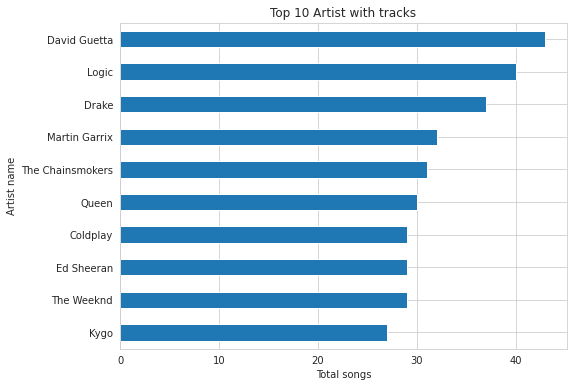

In [ ]:
plt.figure(figsize=(8,6))
sp.groupby('track_artist')['track_name'].count().sort_values(ascending = True).tail(10).plot(kind = 'barh')
plt.title("Top 10 Artist with tracks")
plt.ylabel('Artist name')
plt.xlabel('Total songs')
plt.show()

###**Features Analysis**

In this heat map we try to find the relationship between the features tracks .In the below heat map we can see positive connection between energy and loudness. 
But the obvious thing is that we see that there is no connection between the other features songs.


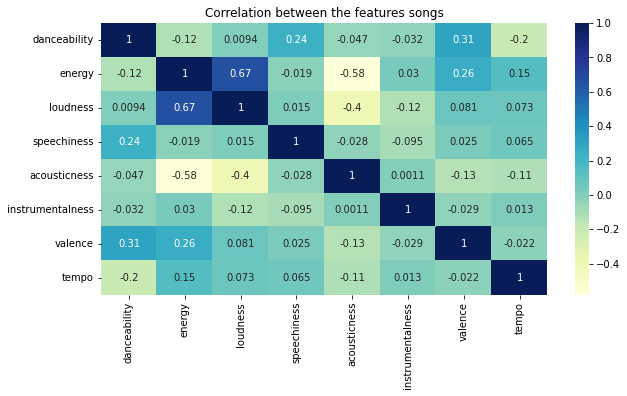

In [45]:
# Plotting a heat map for corr Correlation between the features songs
cor_track  = sp[['danceability', 'energy', 'loudness','speechiness',
       'acousticness', 'instrumentalness', 'valence', 'tempo']]
plt.figure(figsize=(10,5))
c= cor_track.corr()
sns.heatmap(c,cmap='YlGnBu',annot=True).set(title='Correlation between the features songs')
plt.show()

 In this table we compare the characteristics of the songs over the years, it can be said that songs remain high in the characteristics of dance and energy. While the acoustics continue to decline, this can be related to all sorts of reasons, it can be seen that there is also a decline in the valence of the songs over the years.

 

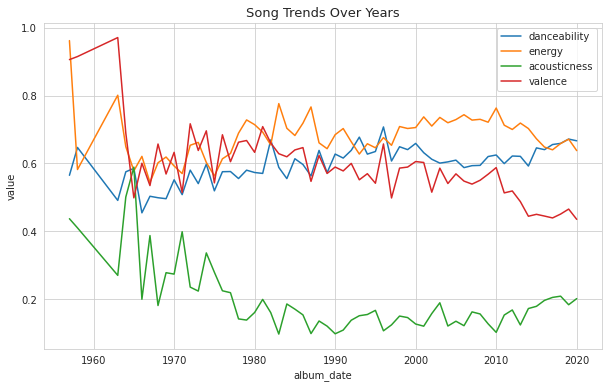

In [ ]:
# Song Trends Over Time
year_avg = sp[['danceability','energy','acousticness','valence','album_date']].groupby('album_date').mean().sort_values(by='album_date').reset_index()
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
lines = ['danceability','energy','acousticness','valence']
for line in lines:
    ax = sns.lineplot( x='album_date',y=line, data=year_avg)
# lineplot.index = 'album_date'
plt.legend(lines)
ax.set_xlim()
plt.ylabel("value")
plt.title("Song Trends Over Years", fontsize=13)
plt.show()


In this chart we can see the genre that lead in each featuer.

We can see that most of the genres have high characteristics of danceability and energy.
also we can say that speechiness and instrumentalness are strong in rap and edm genre's and they are not in top genre.

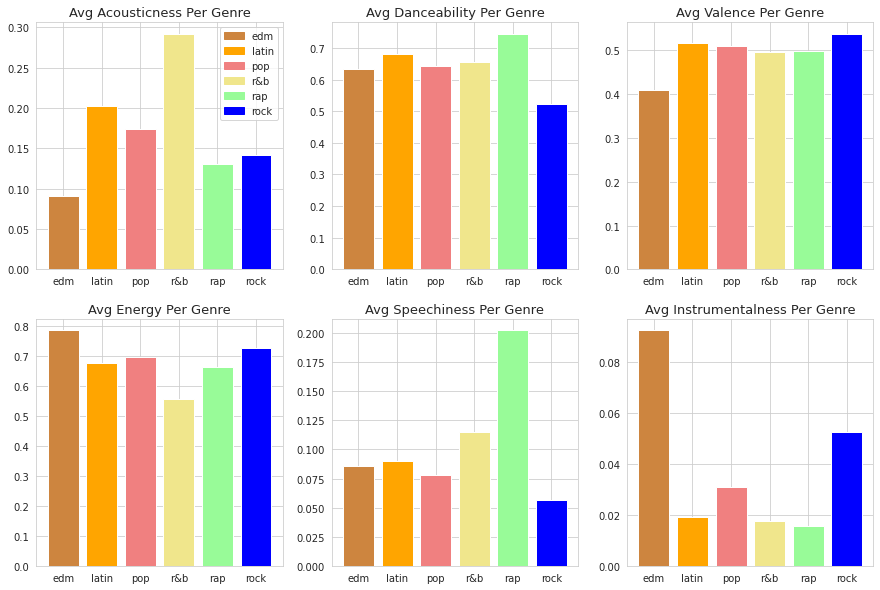

In [ ]:
features = sp[['playlist_genre','danceability', 'energy', 'speechiness', 'acousticness','instrumentalness','valence']]
f = pd.DataFrame(features.groupby('playlist_genre').mean())
f.reset_index("playlist_genre", inplace = True)
palete = {'edm':'peru', 'latin':'orange', 'pop':'lightcoral', 'r&b':'khaki', 'rap':'palegreen','rock':'blue'}
labels = list(palete.keys())

fig, ax = plt.subplots(2, 3, figsize = (15, 10))
ax[0, 0].bar(f['playlist_genre'], f["acousticness"], color=palete.values())
ax[0, 0].set_title("Avg Acousticness Per Genre", fontsize = 13)
ax[0, 1].bar(f['playlist_genre'], f["danceability"], color=palete.values())
ax[0, 1].set_title("Avg Danceability Per Genre", fontsize = 13)
ax[0, 2].bar(f['playlist_genre'], f["valence"], color=palete.values())
ax[0, 2].set_title("Avg Valence Per Genre", fontsize = 13)
ax[1, 0].bar(f['playlist_genre'], f["energy"], color=palete.values())
ax[1, 0].set_title("Avg Energy Per Genre", fontsize = 13)
ax[1, 1].bar(f['playlist_genre'], f["speechiness"], color=palete.values())
ax[1, 1].set_title("Avg Speechiness Per Genre", fontsize = 13)
ax[1, 2].bar(f['playlist_genre'], f["instrumentalness"], color=palete.values())
ax[1, 2].set_title("Avg Instrumentalness Per Genre", fontsize = 13)


handles = [plt.Rectangle((0,0),1,1, color=palete[l]) for l in labels]
ax[0, 0].legend(handles, labels)
plt.show()

Here we want to check if there is an effect of the release date of the song with the popularity, we can see that songs released in December have gained high popularity compared to the other months but not by a big margin.

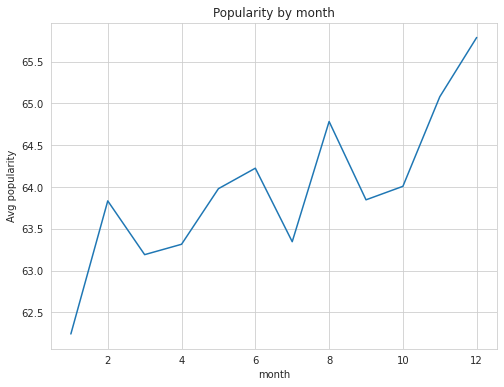

In [ ]:
sp.groupby('month')['track_popularity'].mean().plot.line(figsize = (8, 6))
sns.set_style('whitegrid')
plt.title('Popularity by month')
plt.ylabel('Avg popularity')
plt.show()

### **Genere Anaysis**

The genre that has the most songs with popularity over 50 is pop.




Here we can see the songs by genre type over the years.
The songs that have come out in recent years and are leading in rank of popularity are from the pop genre compared to previous years that rock was higher.

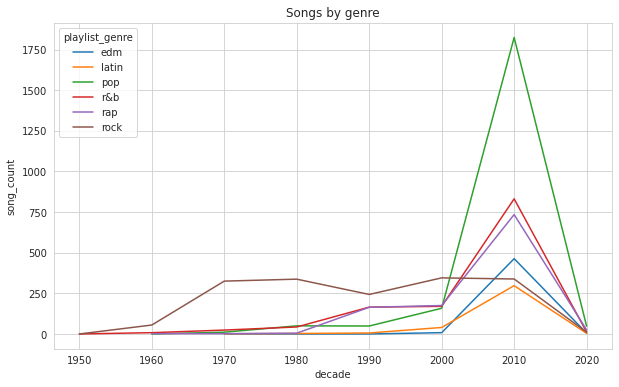

In [ ]:
genre_list = sp.playlist_genre.value_counts().index[:10]
df_genre = sp[sp.playlist_genre.isin(genre_list)][["playlist_genre",'decade',
'energy']].groupby(["playlist_genre",'decade']).count().reset_index()
df_genre.rename(columns={'energy':'song_count'}, inplace=True)
df_genre
plt.figure(figsize=(10,6))
sns.lineplot(x='decade', y='song_count', hue='playlist_genre', data=df_genre)
plt.title('Songs by genre')
plt.show()

Distribution of the songs length according to the genres.

Most songs are in length between 3-4 minutes,
but we can say that rock genre has quite a few songs with over 5 minutes, and we have also seen that in this genre there are few words so it can be said that these songs are characterized most by music.

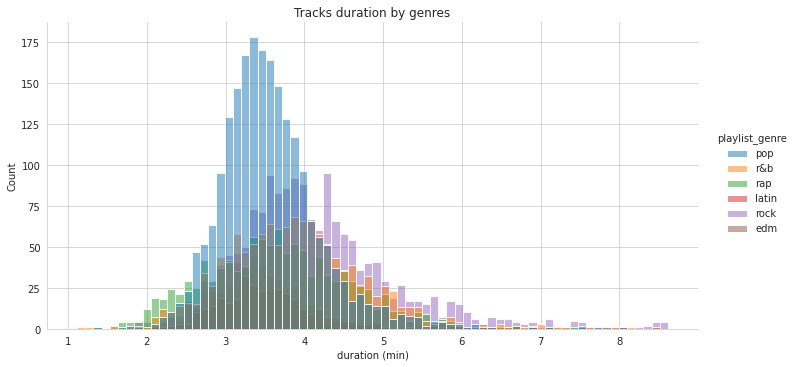

In [ ]:
new_df = sp
new_df['duration_minutes'] = new_df['track_length']/60000
sns.displot(new_df, x='duration_minutes', hue="playlist_genre" , height=5 , aspect =2 )
sns.set_style('whitegrid')
plt.title('Tracks duration by genres')
plt.xlabel('duration (min)')
plt.ylabel('Count')
plt.show()

Songs according to genre and sub-genre.

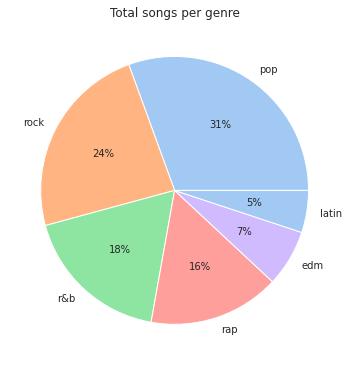

In [ ]:
data = sp.playlist_genre.value_counts().tolist()
labels = ['pop', 'rock', 'r&b', 'rap', 'edm', 'latin']
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(6,8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Total songs per genre')
plt.show()

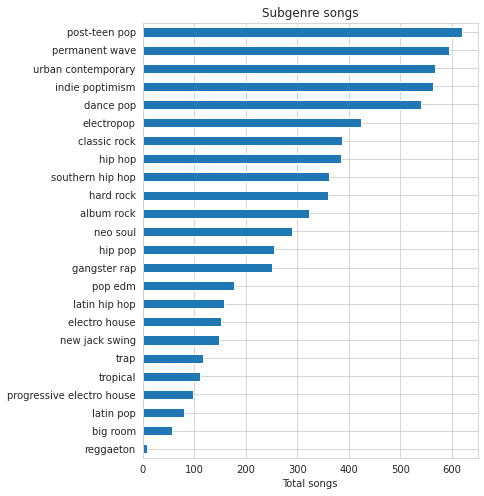

In [ ]:
# ploting in bar chart prtition by sub genre
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
sp['playlist_subgenre'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(6, 8))
plt.title("Subgenre songs")
plt.xlabel('Total songs')
plt.show()

###**Lyrics songs - Text mining**##

We took the songs that has over 75 in the rank popularity and they are in the top 3 Genre and showed their common words in the songs.
and we can see different between them.

In [ ]:
nltk.download('stopwords')

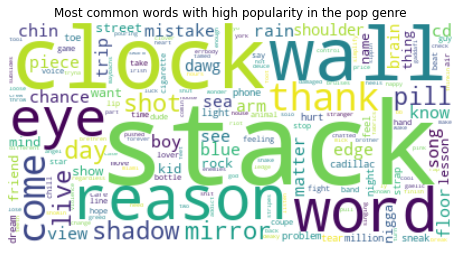

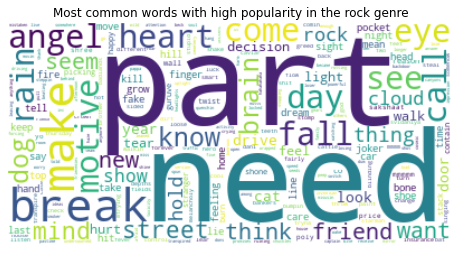

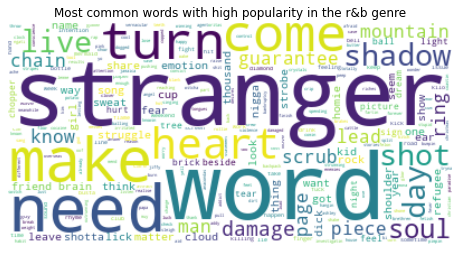

In [47]:
# main function to plot the word cloud
def word_cloud_chart(data_ , genre) :
  lyrics_data = ' '.join(data_['lyrics'].str.lower())
  text = lyrics_data
  text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
  lyrics_data = text.split()
  lyrics_data_words = set([w for w in lyrics_data if w not in stopwords.words("english")])
  lyrics_data_words = ' '.join(lyrics_data_words)
  wc = WordCloud(background_color="white", max_words=1000, random_state=1 ,
                stopwords=STOPWORDS, contour_width=1, contour_color= "white")
  wc.generate(lyrics_data_words)
  plt.figure(figsize=[8,10])
  plt.imshow(wc, interpolation='bilinear')
  plt.title(f'Most common words with high popularity in the {genre} genre')
  plt.axis("off")
  plt.show()
  print()

# showing the common words in the top 3 genre lyrics
listsgenres = ['pop', 'rock', 'r&b']
for genre in listsgenres:
  word_cloud_chart(sp[(sp['playlist_genre'] ==genre) & (sp['track_popularity'] > 70) ].head(50) , genre)

The amount of lyrics of the top 50 songs in the top 3 genre

In [48]:
# main function to print the words count and avg fro genres
def avg_words(datas, genre):
  d_lyrics = ' '.join(datas['lyrics'].str.lower())
  text = d_lyrics
  d_lyrics = text.split(" ")
  d_lyrics_words = [w for w in d_lyrics if w not in stopwords.words("english")]
  print(f'The top 50 popular tracks in the {genre} genre have a total of \
  {len(d_lyrics_words)} words, an avg of {len(d_lyrics_words)/50:.0f} words per song ')

# showing the words in the top 3 genre lyrics 
for genre in listsgenres:
  avg_words(sp[(sp['playlist_genre'] ==genre) & (sp['track_popularity'] > 70) ].head(50) , genre)

The top 50 popular tracks in the pop genre have a total of   25272 words, an avg of 505 words per song 
The top 50 popular tracks in the rock genre have a total of   9256 words, an avg of 185 words per song 
The top 50 popular tracks in the r&b genre have a total of   13777 words, an avg of 276 words per song 


Working with spacy to find patterns in the lyrics of the songs according to the popular genres

In [ ]:
nlp = spacy.load('en_core_web_md')

In [ ]:
lyrics_data = sp[['playlist_genre',"lyrics","language","track_popularity"]]
pop_data = lyrics_data[lyrics_data['playlist_genre'].isin(["pop"])& (lyrics_data['track_popularity'] > 70)&(lyrics_data['language'] =='en')]
pop_data = pop_data.sort_values(by = "track_popularity",ascending = False).head(50)

rock_data = lyrics_data[lyrics_data['playlist_genre'].isin(["rock"])& (lyrics_data['track_popularity'] > 70)&(lyrics_data['language'] =='en')]
rock_data = rock_data.sort_values(by = "track_popularity",ascending = False).head(50)

r_n_b_data = lyrics_data[lyrics_data['playlist_genre'].isin(["r&b"])& (lyrics_data['track_popularity'] > 70)&(lyrics_data['language'] =='en')]
r_n_b_data = r_n_b_data.sort_values(by = "track_popularity",ascending = False).head(50)

selceted_genres = pd.concat([pop_data, rock_data, r_n_b_data], axis=0)
lyrics_data = selceted_genres[["playlist_genre","lyrics"]]
lyrics_data.set_index("playlist_genre",inplace=True)
lyrics_data =lyrics_data.groupby('playlist_genre')['lyrics'].unique()
# main function to create the lyrics
def lyrcis_g(data_lyrics) :
  data_lyrics = data_lyrics.split()
  data_lyrics = [item for item in data_lyrics if item.isalpha()==True]
  data_lyrics = ' '.join(data_lyrics)
  return data_lyrics

# # for pop
pop_lyrics = lyrcis_g(' '.join(dict(pop_data)['lyrics']).lower())
rock_lyrics = lyrcis_g(' '.join(dict(rock_data)['lyrics']).lower())
rnb_lyrics = lyrcis_g(' '.join(dict(r_n_b_data)['lyrics']).lower())

In [ ]:
# Counting the common words and displaying the unique words in pop genre
def try_lyrics(data) :
  _genre_lyrics = (data)
  _genre_lyrics = nlp(_genre_lyrics)
  words = [token.text for token in _genre_lyrics if not token.is_stop and not token.is_punct]
  word_freq = Counter(words)
  common_words = word_freq.most_common(10)
  print(common_words)
  unique_words = [word for (word, freq) in word_freq.items() if freq == 1]
  print("The unique words are: ", unique_words[:25])

# for pop genre 
print('Counting the common words and displaying the unique words in pop genre :')
try_lyrics(pop_lyrics)
# for rock genre 
print()
print('Counting the common words and displaying the unique words in rock genre :')
try_lyrics(rock_lyrics)
# for genre genre 
print()
print('Counting the common words and displaying the unique words in r&b genre:')
try_lyrics(rnb_lyrics)

Counting the common words and displaying the unique words in pop genre :
[('like', 642), ('know', 591), ('got', 475), ('yeah', 471), ('let', 424), ('ride', 393), ('oh', 374), ('feel', 353), ('love', 339), ('come', 320)]
The unique words are:  ['trampoline', 'air', 'float', 'suddenly', 'erupts', 'flames', 'alight', 'spread', 'leaves', 'stream', 'weight', 'solid', 'home', 'breakfast', 'bottles', 'bubbles', 'tattoos', 'trouble', 'lashes', 'atm', 'machines', 'tied', 'calls', 'strings', 'checks']

Counting the common words and displaying the unique words in rock genre :
[('na', 220), ('got', 121), ('know', 99), ('time', 80), ('yeah', 78), ('like', 77), ('feel', 76), ('let', 73), ('gon', 70), ('away', 65)]
The unique words are:  ['escape', 'reality', 'skies', 'sympathy', 'gun', 'begun', 'thrown', 'sends', 'shivers', 'aching', 'silhouetto', 'thunderbolt', 'frightening', 'galileo', 'figaro', 'magnifico', 'spare', 'monstrosity', 'beelzebub', 'devil', 'aside', 'stone', 'spit', 'alive', 'floating

##**Summary and Conclusions :**

Some insight that we have learned from our data analysis: 

1. Pop music control the music market, in quantity of songs and popularity rank .

2.   Songs  from the recent years get a higher popularity rating than past hits, we could see few past singers with high popularity.

3. Actually There’s no correlation between track features we have seen that songs with features like dancability and energy have high popularity.

4. We have also seen that there is a decline in the acoustics and valence of the songs over the years.

5. In terms of lyrics we found differences in content by genres.

